In [79]:
import numpy as np
import matplotlib.pyplot as plt

In [80]:
np.random.seed(0)

In [81]:
a, b, c = 0, 10, 100

### 1. Trapezoid approx

In [82]:
from scipy.special import beta

def p(x, a=0, b=10, c=100):
    x = np.asarray(x)
    
    _alpha = 1 + 4 * (b - a) / (c -a)
    _beta =  1 + 4 * (c - b) / (c - a)
    
    pdf = np.zeros_like(x)
    support = (x >= a) & (x <= c)
    
    pdf[support] = ((x[support] - a)**(_alpha - 1) * (c - x[support])**(_beta - 1)) / (beta(_alpha, _beta) * (c - a)**(_alpha + _beta - 1))    
    return pdf 

In [83]:
E_X = (a + 4*b + c) / 6
var_X = ((E_X - a) * (c - E_X)) / 7

E_X, var_X

(23.333333333333332, 255.55555555555557)

In [84]:
def integrand(x):
    return x * p(x)


def trapezoid(f, a, b, n=1000):
    x = np.linspace(a, b, n + 1)
    y = f(x)
    h = (b - a) / n
    T = h * (y[0]/2 + y[1:-1].sum() + y[-1]/2)
    return T

In [85]:
trapezoid(integrand, a, b)

np.float64(1.2914794278720907)

In [91]:
for i in range(1,2000):
    error = np.abs(E_X - trapezoid(integrand, a, c, n=i))
    if error < 5e-5:    # 4 decimal places
        print(f"Converged at n={i} with error={error:.6f}")
        break

Converged at n=271 with error=0.000050


In [87]:
# h = (b-a)/n;
# T = (f(a)+f(b))/2;
#    for i = 1:n-1
#       T = T + f(a+i*h);
#    end
# T = T*h;

### 2. CLT estimation

E_n = N(E[X], (c - a)^2 sigma**2 / n) \
E[x] = 1.96 * (c - a) sigma / sqrt(n)

n >= ((1.96 * (c - a) sigma) / error)**2

In [ ]:
n0 = 1000
x = np.random.uniform(a, c, n0)

y = x * p(x)
sigma_hat = np.std(y, ddof=1)

target_error = 5e-3 # 2 decimals
z = 1.96  # for 95% confidence interval
n_req = (z * (c - a) * sigma_hat / target_error)**2   
n_req

np.float64(57240358.36635303)

### 3. Verify the estimates

In [92]:
n = int(np.ceil(n_req))

n_estimates = 15
for _ in range(n_estimates):
    x = np.random.uniform(a, c, n)
    fx = c * integrand(x)

    mean = np.mean(fx)
    std_dev = np.std(fx) / np.sqrt(n)    
    
    error = np.abs(mean - E_X)
    print(f"Estimate: {mean:.6f}, Std Dev: {std_dev:.6f}, Error: {error:.6f}")    
    

Estimate: 23.333413, Std Dev: 0.002522, Error: 0.000080
Estimate: 23.333425, Std Dev: 0.002522, Error: 0.000092
Estimate: 23.334279, Std Dev: 0.002522, Error: 0.000945
Estimate: 23.333749, Std Dev: 0.002522, Error: 0.000415
Estimate: 23.333410, Std Dev: 0.002522, Error: 0.000077
Estimate: 23.330469, Std Dev: 0.002522, Error: 0.002864
Estimate: 23.330200, Std Dev: 0.002522, Error: 0.003134
Estimate: 23.335562, Std Dev: 0.002522, Error: 0.002228
Estimate: 23.333523, Std Dev: 0.002522, Error: 0.000190
Estimate: 23.337685, Std Dev: 0.002522, Error: 0.004352
Estimate: 23.328189, Std Dev: 0.002522, Error: 0.005144
Estimate: 23.335516, Std Dev: 0.002522, Error: 0.002183
Estimate: 23.334233, Std Dev: 0.002522, Error: 0.000899
Estimate: 23.332207, Std Dev: 0.002522, Error: 0.001127
Estimate: 23.333281, Std Dev: 0.002522, Error: 0.000053


### All estimates below 0.005, therefore the estimate is correct

### Comparison, discussion
Trapezoid up to 4 decimals with < 1k iterations while MC integration requires milions just to reach second decimal accuracy, so in this case the trapezoid is much more efficient

## 2. Importance sampling

In [93]:
def f(x):
    return x ** (-0.75) + np.exp(-x)

### 2.1 Plot on [0, 1]

C:\Users\sebas\AppData\Local\Temp\ipykernel_1856\1656614922.py:2: RuntimeWarning: divide by zero encountered in power
  return x ** (-0.75) + np.exp(-x)


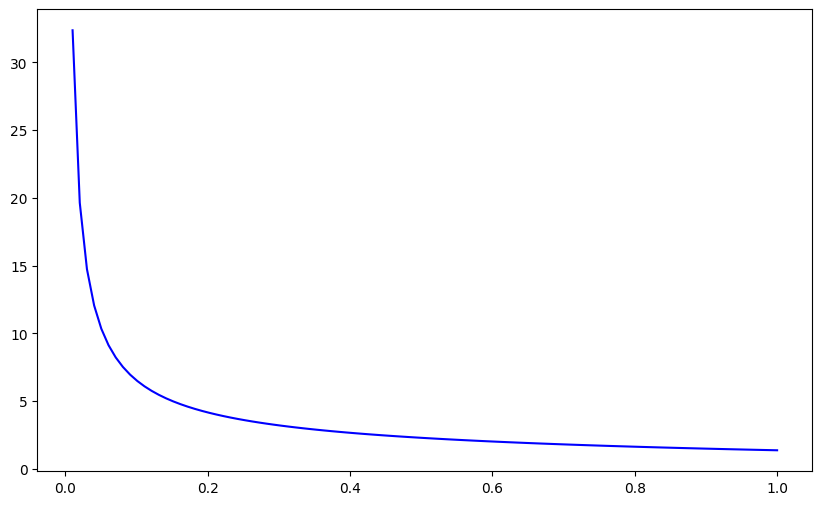

In [96]:
x = np.linspace(0, 1, 100)
plt.figure(figsize=(10, 6))
plt.plot(x, f(x), label='f(x) = x^(-0.75) + exp(-x)', color='blue')


### 2.2 Uniform sample MC

In [98]:
n = 10e7

estimates = []

for _ in range(10):
    x = np.random.uniform(0, 1, int(n))
    fx = f(x)
    
    est = (b - a) * np.mean(fx)
    estimates.append(est)
    
estimates = np.array(estimates)
mean_I = np.mean(estimates)
std_I = np.std(estimates)

print(f"Mean Estimate: {mean_I:.6f}, Std Dev: {std_I:.6f}")


Mean Estimate: 46.613548, Std Dev: 0.998660


### 2.3 Estimate I by q

In [111]:
# I x^{-3/4} dx = [x^{1/4} / (1/4)] = 4, so c = 1/4
n = int(10e7)
c = 1/4


def q(x, c=1/4):
    return c * x**(-0.75)

def cdf_q(x):
    return x ** 0.25

def inv_cdf_q(x):
    return x ** 4

estimates = []
for _ in range(10):
    u = np.random.uniform(1e-10, 1, size=n)
    x = inv_cdf_q(u)
    fx = f(x)
    qx = q(x)
    W = fx / qx
    
    estimates.append(np.mean(W) * (b - a))

In [105]:
np.mean(estimates), np.std(estimates)

(np.float64(0.006506639413147555), np.float64(7.070352635499551e-07))